In [1]:
import sympy as sym
import numpy as np
import matplotlib.pyplot as plt
from numba import jit,njit

In [2]:
# @jit(nopython=True)
def Jss(q,S=1,SD=0,n=83,r=2):
    def Js(s):
        if s > r:
            Js = 0
        else: 
            Js = S/(2*r) * np.cos(2*np.pi*q/n*s)
            # JSD = SD/(r*(2*r-1)) * (1+np.cos(2*np.pi*q/n)+np.cos(6*np.pi*q/n))
            JSD = SD/(r*(2*r-1)) * (np.sum(np.cos(2*np.pi*q/n*(s+np.arange(-r,r+1,1)))) - np.cos(2*np.pi*q*s/n)  - np.cos(4*np.pi*q*s/n))
        return Js +JSD
    Jss = np.zeros(n)

    for i in range(1,r+1):
        Jss[i] = Js(i)
        Jss[-i] = Js(i)
        # print(Js(1))
    Jss[0] = -np.sum(Jss)
    return Jss

In [3]:
# @jit(nopython=True)
def get_E(p,n=83):
    e = np.exp(1j*2*np.pi*np.arange(n)*p/n)
    return e
# @jit(nopython=True)
def get_lambda(q,S=1,SD=0,n=83,r=1):
    lambdas = np.array([np.real(np.sum(Jss(q,S=S,SD=SD,r=r,n=n)*get_E(i,n=n))) for i in range(1,n)])
    return lambdas


In [4]:
from parfor import parfor
import ray

In [5]:
n = 83
SD = np.linspace(0,10,100)

In [7]:
@parfor(SD,(2,1,83))
def P(SD,r=4,S=1,n=n):
    As = [] 
    for i in range(n):
        a = np.max(get_lambda(i,r=r,S=S,SD=SD,n=n))
        As.append(a)
    As = np.array(As)
    Lp,=np.where(As<0)
    P = len(Lp)/n
    return P

  0%|          | 0/100 [00:00<?, ?it/s]

In [7]:
get_P = np.vectorize(P)

In [6]:
qs = np.arange(n)
@parfor(qs)
def get_lambdas(i,r=2,S=1,SD=1,n=n):
    a = np.max(get_lambda(i,r=r,S=S,SD=SD,n=n))
    return a

  0%|          | 0/83 [00:00<?, ?it/s]

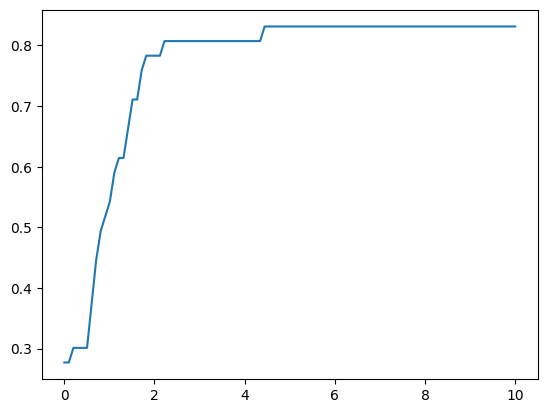

In [20]:
plt.plot(SD,P)

In [87]:
SD = ray.put(SD.tolist())

In [88]:
result = ray.get(P.remote(SD))

RayTaskError(TypeError): [36mray::P()[39m (pid=93469, ip=127.0.0.1)
  File "/var/folders/z1/v9g3442s1hn29m34fht7zq8h0000gn/T/ipykernel_89006/690790175.py", line 5, in P
  File "/var/folders/z1/v9g3442s1hn29m34fht7zq8h0000gn/T/ipykernel_89006/5231952.py", line 7, in get_lambda
  File "/var/folders/z1/v9g3442s1hn29m34fht7zq8h0000gn/T/ipykernel_89006/5231952.py", line 7, in <listcomp>
  File "/var/folders/z1/v9g3442s1hn29m34fht7zq8h0000gn/T/ipykernel_89006/4265090000.py", line 14, in Jss
  File "/var/folders/z1/v9g3442s1hn29m34fht7zq8h0000gn/T/ipykernel_89006/4265090000.py", line 9, in Js
TypeError: unsupported operand type(s) for /: 'list' and 'int'

In [58]:
n = 83
SD = np.linspace(0,10,100)

@parfor(SD)
def P(SD,r=4,S=1,n=n):
    As = [] 
    for i in range(n):
        a = np.max(get_lambda(i,r=r,S=S,SD=SD,n=n))
        As.append(a)
    As = np.array(As)
    Lp,=np.where(As<0)
    P = len(Lp)/n
    return P
# get_P = np.vectorize(P)

  0%|          | 0/100 [00:00<?, ?it/s]

In [31]:
SD = np.linspace(0,10,100)
Ps =get_P(SD,r = 1,S = 1,n=n)

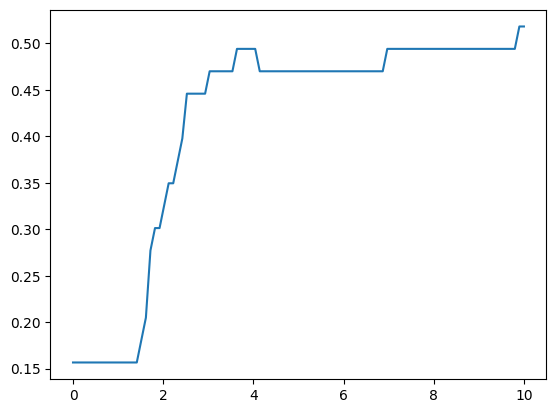

In [59]:
plt.plot(SD,P)
# plt.ylim(0,1)

In [38]:
As = [] 
n = 83
x = np.linspace(0,1,n)

for i in range(n):
    a = np.max(get_lambda(i,r=2,S=1,SD=1,n=n))
    As.append(a)
As = np.array(As)

In [32]:
P = len(np.where(As<0)[0])/n
P

0.4939759036144578

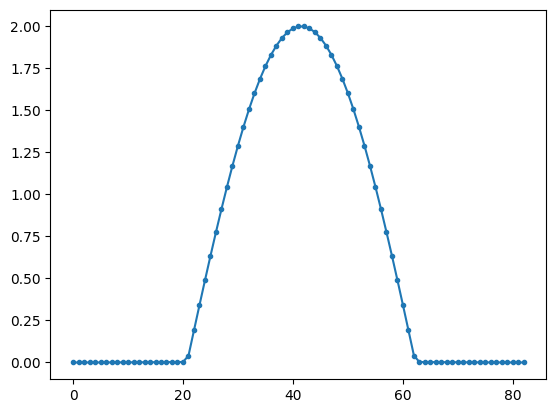

In [34]:
plt.plot(As,'.-')


([<matplotlib.axis.XTick at 0x137ca46d0>,
 [Text(0, 0, '0'),
  Text(14, 0, '14'),
  Text(23, 0, '23'),
  Text(30, 0, '30'),
  Text(69, 0, '69'),
  Text(60, 0, '60'),
  Text(53, 0, '53'),
  Text(83, 0, '83')])

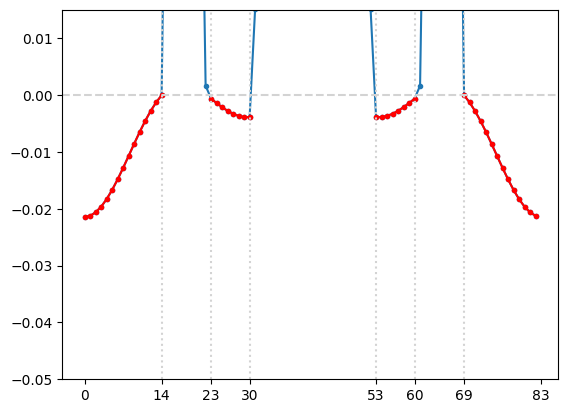

In [39]:
L_S = np.where(As<0,As,np.nan)
plt.plot(As,'.-')
plt.plot(L_S,'.-',color='red')
plt.ylim(-0.05,0.015)
plt.axhline(0,ls='--',color='lightgray')
plt.axvline(14,ls=':',color='lightgray')
plt.axvline(23,ls=':',color='lightgray')
plt.axvline(30,ls=':',color='lightgray')
plt.axvline(83-14,ls=':',color='lightgray')
plt.axvline(83-23,ls=':',color='lightgray')
plt.axvline(83-30,ls=':',color='lightgray')

plt.xticks([0,14,23,30,83-14,83-23,83-30,n])
# plt.plot(x2,As2,'+-')
# plt.plot(As2,'+-')
# plt.plot(As2,'+-')
# plt.ylim(-0.2,0)

In [51]:
np.max(get_lambda(0))

0j

In [49]:
np.sum(Jss(3,r=1)*get_E(1))

(-0.0027904162114914532-1.3183898417423734e-16j)

In [8]:
n = 83
-1 % n 

82

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from scipy.stats import mode, norm

### ANIMATAION 관련 ###
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from scipy.stats import mode, norm

### ANIMATAION 관련 ###
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128

In [64]:
@jit(nopython = True)
def RK4(f, y0, t, args=()):
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0

    for i in range(n - 1):
        h = t[i + 1] - t[i]
        k1 = f(y[i], t[i], *args)
        k2 = f(y[i] + k1 * h / 2.0, t[i] + h / 2.0, *args)
        k3 = f(y[i] + k2 * h / 2.0, t[i] + h / 2.0, *args)
        k4 = f(y[i] + k3 * h, t[i] + h, *args)
        y[i + 1] = y[i] + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return y

@jit(nopython = True)
def Kuramoto(Theta,t,omega,N,Aij,Bijk):
    Theta = Theta.copy()
    theta = Theta[:N]
    theta_i= theta.reshape(1,-1)
    theta_j = theta_i.T
    # theta_i,theta_j = np.meshgrid(theta,theta,sparse=True)
    dtheta = omega +  np.sum(Aij*np.sin(theta_j - theta_i),axis=0)
    Theta[:N] = dtheta
    return Theta

In [82]:
# System size & Nearest neigbors number k setting
N = 73
k = 2


K = 1
Aij = np.zeros((N,N))
for i in range(N):
    j = np.arange((i-k),(i+k+1),1)%N
    Aij[i,j]= K/(2*k)
    Aij[i,i] = 0

KD = 1

Bijk = np.zeros((N,N,N))
for i in range(N):
    j = np.arange((i-k),(i+k+1),1)%N
    k_ = np.arange((i-k),(i+k+1),1)%N
    for j_ in j:
        Bijk[i,j_,k_]= KD / (2*k*(2*k-1))
for i in range(N):
    Bijk[:,i,i] = 0
    Bijk[i,i,:] = 0
    Bijk[i,:,i] = 0 


In [125]:
x3,y3,z3 = np.where(Bijk!=0)
x2,y2 = np.where(Aij!=0)

In [126]:
indexing_tri =  list(zip(x3,y3,z3))
indexing_p =  list(zip(x2,y2))

In [110]:
set_3 = set()
for x in indexing_tri:
    set_3.add(frozenset([*x]))
set_2 = set()
for x in indexing_tri:
    set_3.add(frozenset([*x]))


In [120]:
indexing_tri = []
for x in set_3:
    indexing_tri.append(list(x))

In [122]:
np.unique(np.array(indexing_tri),return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72]),
 array([12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12]))

In [ ]:
dt = 0.1
t_end = 1000
t = np.arange(0, t_end+dt/2, dt)
Q_want = [4]
Q = 6
while Q not in Q_want:
    omega = 0
    theta_random = np.random.uniform(-np.pi, np.pi, size=N)
    sol = RK4(Kuramoto,theta_random,t, args=(omega,N,Aij))
    theta_s = sol[:,:N]
    Q = mode(np.round(np.diff((theta_s[-1]-np.pi)%(np.pi*2)+np.pi) / (np.pi*2/N),1))[0]
    rphi = (np.mean(np.exp(1j*theta_s.T),axis=0))
    r = np.abs(rphi)
    Q, np.mean(r[-500:])
    psi = np.angle(rphi)
    rtheta_s = (theta_s.T-psi).T
    print(int(Q))

1
0
1
0
1
0
0
0
-1
0
-2
-1
-3
1
0
-1
0
0
2
2
0
1
-1
0
-1
0
0
0
1
2
0
0
-1
0
2
0
-1
1


KeyboardInterrupt: 

In [142]:
# @jit(nopython = True)
def RK4(f, y0, t, args=()):
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0

    for i in range(n - 1):
        h = t[i + 1] - t[i]
        k1 = f(y[i], t[i], *args)
        k2 = f(y[i] + k1 * h / 2.0, t[i] + h / 2.0, *args)
        k3 = f(y[i] + k2 * h / 2.0, t[i] + h / 2.0, *args)
        k4 = f(y[i] + k3 * h, t[i] + h, *args)
        y[i + 1] = y[i] + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return y

@jit(nopython = True)
def Kuramoto(Theta,t,omega,N,Aij):
    Theta = Theta.copy()
    theta = Theta[:N]
    theta_i= theta.reshape(1,-1)
    theta_j = theta_i.T
    # theta_i,theta_j = np.meshgrid(theta,theta,sparse=True)
    dtheta = omega +  np.sum(Aij*np.sin(theta_j - theta_i),axis=0)
    Theta[:N] = dtheta
    return Theta

In [ ]:
# System size & Nearest neigbors number k setting
N = 73
k = 2
Aij = np.zeros((N,N))
for i in range(N):
    j = np.arange((i-k),(i+k+1),1)%N
    Aij[i,j]= 1
    Aij[i,i] = 0

In [ ]:
dt = 0.1
t_end = 1000
t = np.arange(0, t_end+dt/2, dt)
Q_want = [4]
Q = 6
while Q not in Q_want:
    omega = 0
    theta_random = np.random.uniform(-np.pi, np.pi, size=N)
    sol = RK4(Kuramoto,theta_random,t, args=(omega,N,Aij))
    theta_s = sol[:,:N]
    Q = mode(np.round(np.diff((theta_s[-1]-np.pi)%(np.pi*2)+np.pi) / (np.pi*2/N),1))[0]
    rphi = (np.mean(np.exp(1j*theta_s.T),axis=0))
    r = np.abs(rphi)
    Q, np.mean(r[-500:])
    psi = np.angle(rphi)
    rtheta_s = (theta_s.T-psi).T
    print(int(Q))

1
0
1
0
1
0
0
0
-1
0
-2
-1
-3
1
0
-1
0
0
2
2
0
1
-1
0
-1
0
0
0
1
2
0
0
-1
0
2
0
-1
1


KeyboardInterrupt: 

In [143]:
# @jit(nopython = True)
def RK4(f, y0, t, args=()):
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0

    for i in range(n - 1):
        h = t[i + 1] - t[i]
        k1 = f(y[i], t[i], *args)
        k2 = f(y[i] + k1 * h / 2.0, t[i] + h / 2.0, *args)
        k3 = f(y[i] + k2 * h / 2.0, t[i] + h / 2.0, *args)
        k4 = f(y[i] + k3 * h, t[i] + h, *args)
        y[i + 1] = y[i] + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return y

# @jit(nopython=True)
def Kuramoto_SOL(Theta,t,Bijk,Aij):
    # print("Case m = 0")
    theta = Theta.copy()
    # theta_i,theta_j = np.meshgrid(theta,theta,sparse=False,indexing='ij')
    i,j,k = np.meshgrid(theta,theta,theta,sparse=False,indexing='ij')
    i_,j_ = np.meshgrid(theta,theta,sparse=False,indexing='ij')
    dtheta = np.sum(np.sum(Bijk*np.sin(j+k-2*i),axis=2),axis=1) + np.sum(Aij*np.sin(j_-i_),axis=1)
    return dtheta

In [414]:
N = 83
k = 2


K = 1
KD = 10


Aij = np.zeros((N,N))
for i in range(N):
    j = np.arange((i-k),(i+k+1),1)%N
    Aij[i,j]= K/(2*k)
    Aij[i,i] = 0

Bijk = np.zeros((N,N,N))
for i in range(N):
    j = np.arange((i-k),(i+k+1),1)%N
    k_ = np.arange((i-k),(i+k+1),1)%N
    for j_ in j:
        Bijk[i,j_,k_]= KD / (2*k*(2*k-1))
for i in range(N):
    Bijk[:,i,i] = 0
    Bijk[i,i,:] = 0
    Bijk[i,:,i] = 0 

In [415]:

dt = 0.1
t_end = 500
t = np.arange(0, t_end+dt/2, dt)

In [416]:
np.round(N/2)

42.0

In [417]:
AN = int(np.round(N/2))
P0  = [1]* AN + [0]*(N-AN)
P1 = np.array(P0.copy())
P2 = np.array(P0.copy())
np.random.shuffle(P1)
np.random.shuffle(P2)

In [431]:
np.random.seed(0)
# theta_random = np.random.uniform(-np.pi, np.pi, size=N)
theta_random = np.arange(N) * (-38*2*np.pi/N)
# a1 = 0.1
# a2 = 1.6
# theta_random += a1*P1 + a2*P2


In [419]:
# theta_random = np.random.uniform(-np.pi, np.pi, size=N)
sol = RK4(Kuramoto_SOL,theta_random,t, args=(Bijk,Aij))

In [420]:
theta_s = sol[:,:N]
rphi = (np.mean(np.exp(1j*theta_s.T),axis=0))
psi = np.angle(rphi)
rtheta_s = (theta_s.T-psi).T
r = np.abs(rphi)

Q = mode(np.round(np.diff((theta_s[-1]-np.pi)%(np.pi*2)+np.pi) / (np.pi*2/N),1))[0]
Q

/var/folders/lj/v2s5sd8n1cv2xdh0yw2kf0x00000gn/T/ipykernel_64155/3949545514.py:7: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  Q = mode(np.round(np.diff((theta_s[-1]-np.pi)%(np.pi*2)+np.pi) / (np.pi*2/N),1))[0]


array([-37.3])

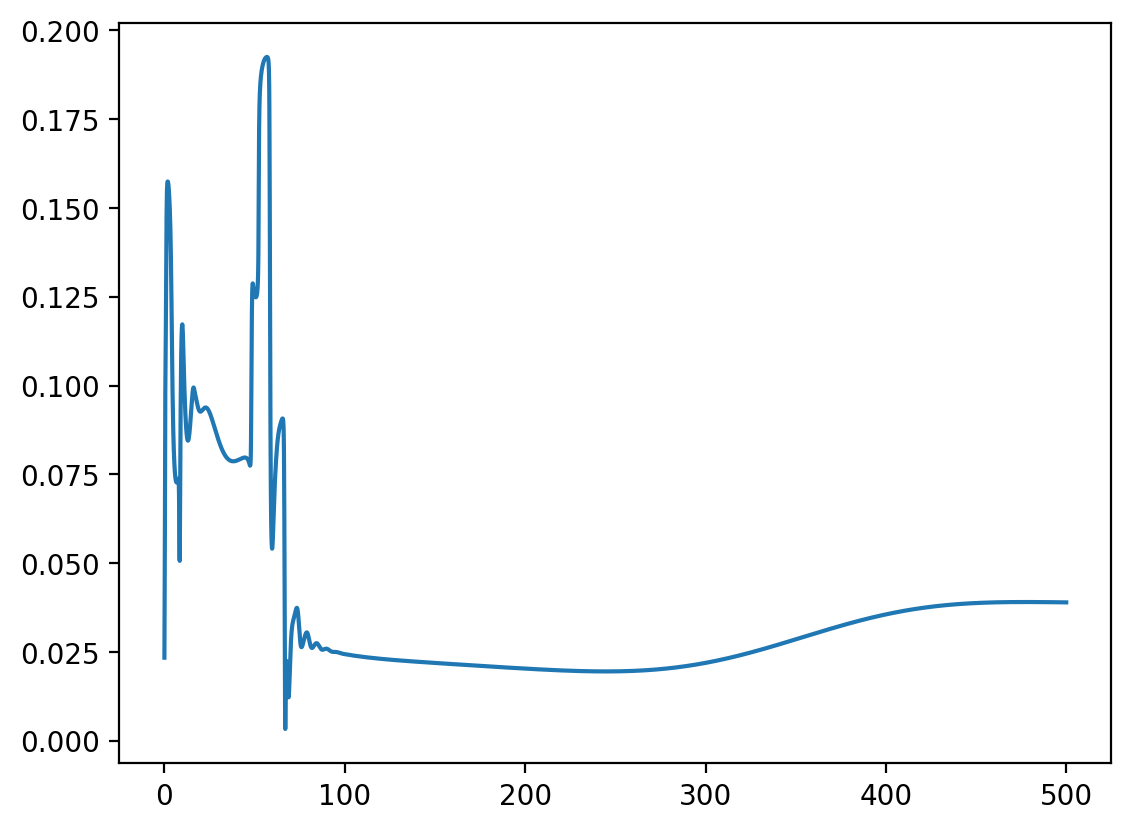

In [421]:
plt.plot(t,r)

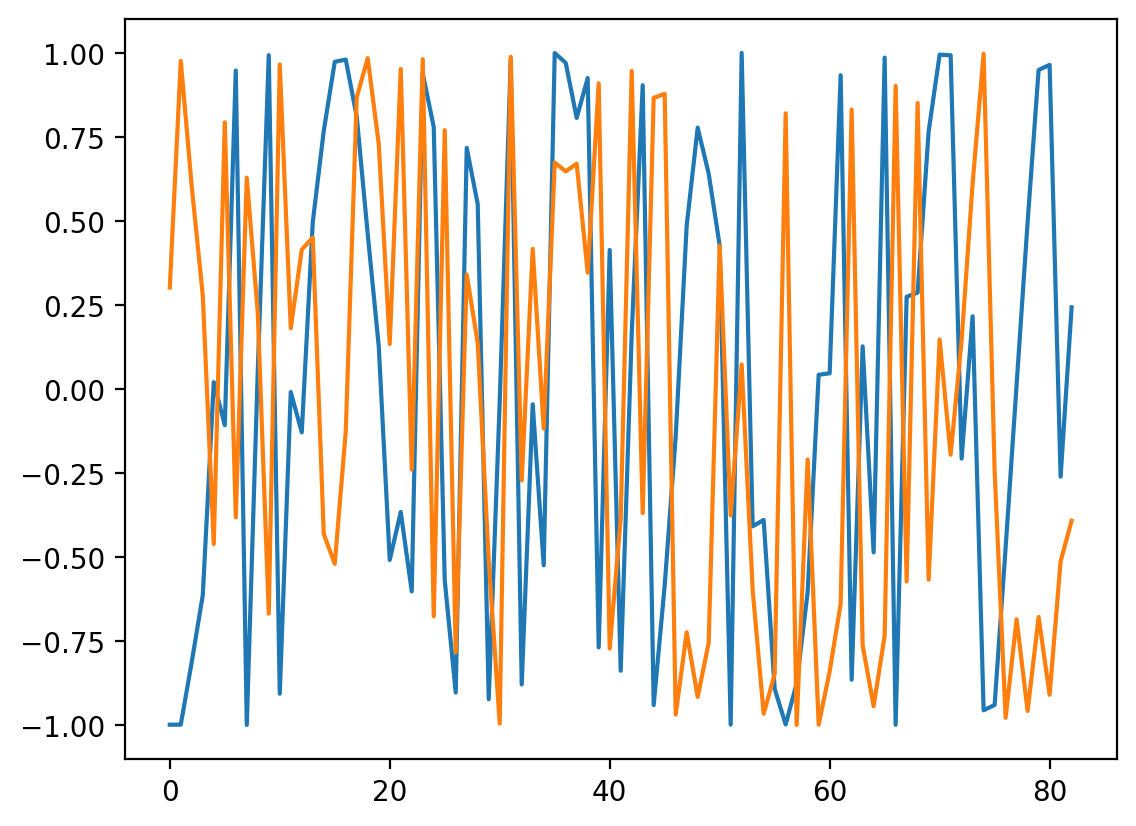

In [422]:
plt.plot(np.sin(sol[-1]))
plt.plot(np.sin(sol[0]))

(-1.2, 1.2, -1.2, 1.2)

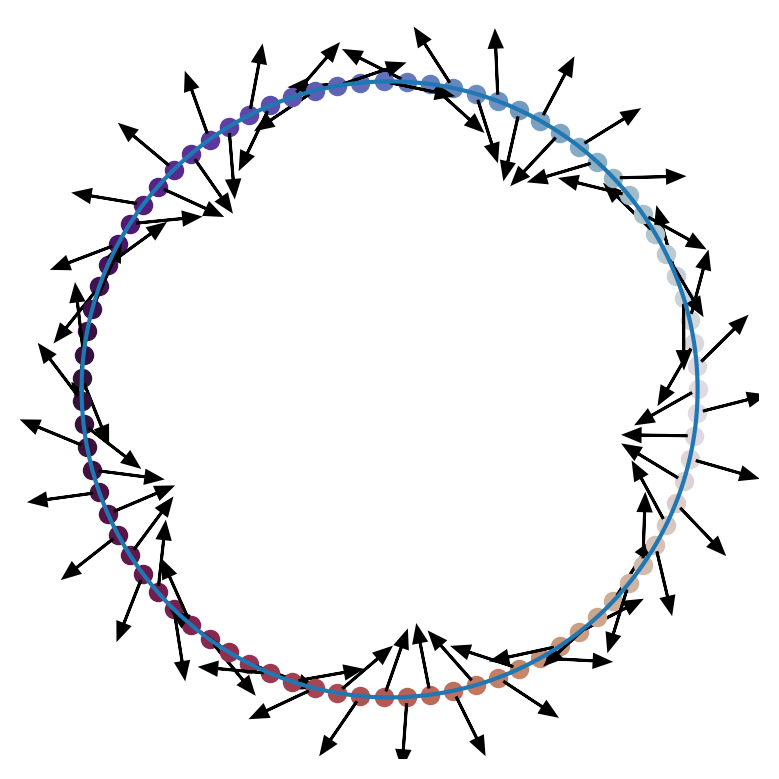

In [432]:
c_ = np.linspace(-np.pi,np.pi,10000)
fig, ax =  plt.subplots(1)
plt.plot(np.cos(c_),np.sin(c_))
plt.gca().set_aspect('equal')


theta_0 = rtheta_s[-1][0]
colors= plt.cm.twilight(np.linspace(0,1,N))
# for j,cm in range(0,100,10),colors:
j = 0
for i,(theta,color) in enumerate(zip(theta_random,colors)):
    o_deg = 2*np.pi*i/N
    o_x ,o_y =np.cos(o_deg),np.sin(o_deg)
    plt.scatter(o_x ,o_y,color=color)
    deg = theta
    x,y = np.cos(deg-theta_0),np.sin(deg-theta_0)
    length = 0.2
    head = 0.05

    ax.arrow(o_x,o_y,x*(length),y*(length),head_starts_at_zero=True,length_includes_head=True,head_width=0.04, head_length=head ,fc='k', ec='k')
ax.set_xlim(-1.2,1.2)
ax.set_ylim(-1.2,1.2)
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')

(-1.2, 1.2, -1.2, 1.2)

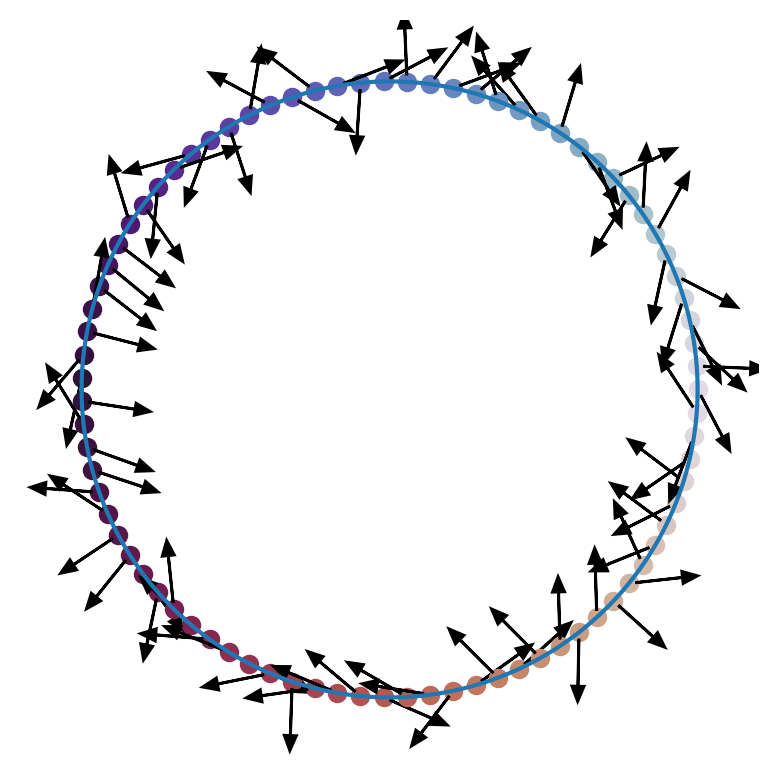

In [423]:
c_ = np.linspace(-np.pi,np.pi,10000)
fig, ax =  plt.subplots(1)
plt.plot(np.cos(c_),np.sin(c_))
plt.gca().set_aspect('equal')


theta_0 = rtheta_s[-1][0]
colors= plt.cm.twilight(np.linspace(0,1,N))
# for j,cm in range(0,100,10),colors:
j = 0
for i,(theta,color) in enumerate(zip(rtheta_s[j],colors)):
    o_deg = 2*np.pi*i/N
    o_x ,o_y =np.cos(o_deg),np.sin(o_deg)
    plt.scatter(o_x ,o_y,color=color)
    deg = theta
    x,y = np.cos(deg-theta_0),np.sin(deg-theta_0)
    length = 0.2
    head = 0.05

    ax.arrow(o_x,o_y,x*(length),y*(length),head_starts_at_zero=True,length_includes_head=True,head_width=0.04, head_length=head ,fc='k', ec='k')
ax.set_xlim(-1.2,1.2)
ax.set_ylim(-1.2,1.2)
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')

In [424]:
def to_animation(idx):
    ax.clear()
    theta_0 = rtheta_s[-1][0]
    # for j,cm in range(0,100,10),colors:
    for i,(theta,color) in enumerate(zip(theta_s[idx],colors)):
        o_deg = 2*np.pi*i/N
        o_x ,o_y =np.cos(o_deg),np.sin(o_deg)
        ax.scatter(o_x ,o_y,color=color)
        deg = theta
        x,y = np.cos(deg-theta_0),np.sin(deg-theta_0)
        length = 0.2
        head = 0.05
        ax.arrow(o_x,o_y,x*(length),y*(length),head_starts_at_zero=True,length_includes_head=True,head_width=0.04, head_length=head ,fc='k', ec='k')
    ax.set_xlim(-1.2,1.2)
    ax.set_ylim(-1.2,1.2)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')

In [425]:
len(t)

5001

In [426]:
%config InlineBackend.figure_format = 'retina'
idxs=  np.arange(0,5000,40)
ani = FuncAnimation(fig,to_animation,frames=idxs,interval=50)

In [427]:
# 저장이 필요할 경우
# ani.save(f'Q_state/Deeper/N = {N}, Q = 12 to {int(Q)},KT = {KD}, a1={a1},a2={a2}.mp4',dpi=400)
ani.save(f'Q_state/Deeper/N = {N}, Q = random to {float(Q)},KT = {KD}.mp4',dpi=400)

/var/folders/lj/v2s5sd8n1cv2xdh0yw2kf0x00000gn/T/ipykernel_64155/2675262436.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ani.save(f'Q_state/Deeper/N = {N}, Q = random to {float(Q)},KT = {KD}.mp4',dpi=400)


In [428]:
# 확인용
HTML(ani.to_html5_video())

In [374]:
R.shape

(5001,)

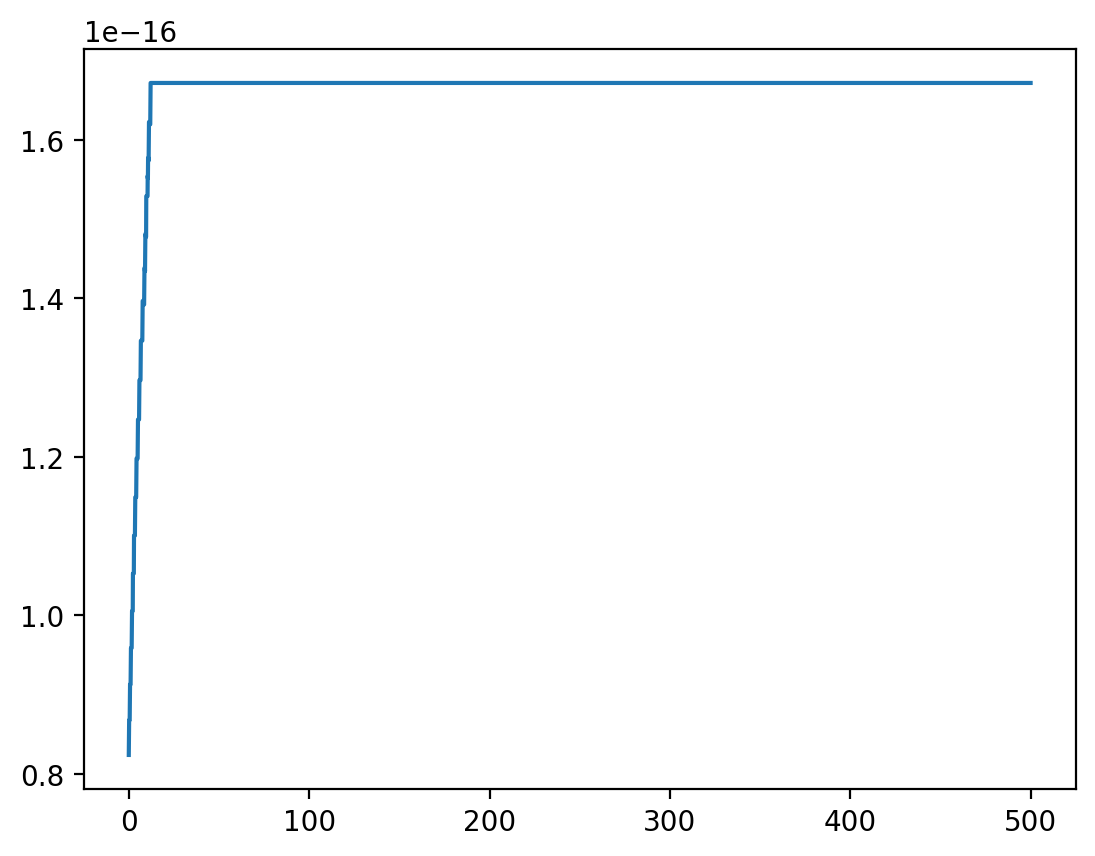

In [279]:
plt.plot(t,abs(R))

In [280]:
def Kuramoto_SOL_integral(Theta,t,omega,n,indexing2,indexing3,K2):
    r2 = np.zeros(n, dtype=complex)
    r1 = np.zeros(n, dtype=complex)
    i_theta = Theta.copy()
    for i,j,k in indexing3:
        r2[i] += np.exp(1j*(i_theta[j]+i_theta[k]))*2
        r2[j] += np.exp(1j*(i_theta[k]+i_theta[i]))*2
        r2[k] += np.exp(1j*(i_theta[j]+i_theta[i]))*2

    for i,j in indexing2:
        r1[i] += np.exp(1j*(i_theta[j]+i_theta[k]))*2
        r1[j] += np.exp(1j*(i_theta[k]+i_theta[i]))*2
    dtheta = omega + K2/(2*r*(2*r-1))*(r2*np.exp(-2j*i_theta)).imag + K1/(2*r) *(r1*np.exp(-1j*i_theta)).imag 
    return dtheta

In [34]:
import ray

ray.init(num_cpus=10)

@ray.remote
def mul(x):
    return x * 10


2024-07-10 23:36:07,781	INFO worker.py:1771 -- Started a local Ray instance.


In [51]:
import numpy as np
import ray
from parfor import parfor
import time

# ray.init(num_cpus=10)

arr = np.random.random(100000)
start = time.time()
@parfor(arr)
def mul(x):
    return x * 10
end = time.time()
print(end - start)
# arr = ray.put(arr)

  0%|          | 0/100000 [00:00<?, ?it/s]

1.9899260997772217


In [52]:
start = time.time()
def mul(x):
    return x * 10
a = []
for i in arr:
    a.append(mul(i))
end = time.time()
print(end - start)


0.04852104187011719


In [ ]:
for i in range(1000)